In [1]:
%load_ext autoreload
%autoreload 2

import os

os.chdir("..")

import json
import torch
import wandb
import torchvision
import torchmetrics
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from src.utils.metrics import metrics, Metrics
from src.data.mri import MRIDataModule
from src.data.covidx import COVIDXDataModule
from src.utils.evaluation import WeightsandBiasEval
from src.models.imageclassifier import ImageClassifier

/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ubuntu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (det

In [2]:
ENTITY = "24FS_I4DS27"
PROJECT = "baselines"
NUM_WORKERS = 1

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224), antialias=True),
    ]
)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

evaluator = WeightsandBiasEval(entity_project_name=f"{ENTITY}/{PROJECT}")

In [3]:
best_models = evaluator.get_best_models()
best_models

,id,model,dataset,epoch,lr,epochs,batch_size,weight_decay,p_dropout_classifier,first_unfreeze_epoch,...,train_BinaryRecall,train_BinarySpecificity,train_loss,val_BinaryAUROC,val_BinaryAccuracy,val_BinaryF1Score,val_BinaryPrecision,val_BinaryRecall,val_BinarySpecificity,val_loss
0,3ibcnbp1,alexnet,covidx_data,0.0,0.00001,50,32,0,0,5.0,...,0.990596,0.007663,1.435608,0.500000,0.500531,0.667139,0.500531,1.000000,0.000000,4.495397
1,x48n43n1,densenet121,covidx_data,47.0,0.00100,50,32,0,0,NaN,...,0.986297,0.859232,0.095050,0.933604,0.858964,0.862121,0.844103,0.880924,0.836957,0.366717
2,69kep6pr,densenet169,covidx_data,30.0,0.00100,50,32,0,0,NaN,...,0.980675,0.683729,0.198558,0.925435,0.835005,0.843484,0.803027,0.888234,0.781664,0.368208
3,fghvm9cs,densenet201,covidx_data,26.0,0.00100,50,32,0,0,NaN,...,0.977864,0.756856,0.162382,0.931639,0.857193,0.861967,0.834917,0.890828,0.823488,0.340752
4,9i2glr7w,efficientnet_v2_l,covidx_data,41.0,0.00010,50,32,0,0,NaN,...,0.960647,0.614260,0.256415,0.908821,0.793816,0.820471,0.727140,0.941287,0.646030,0.504318
5,mym2lvia,efficientnet_v2_m,covidx_data,44.0,0.00001,50,32,0,0,NaN,...,0.977161,0.270567,0.343028,0.876601,0.735159,0.779914,0.667674,0.937515,0.532372,0.534945
6,cnovpv82,efficientnet_v2_s,covidx_data,28.0,0.00001,50,32,0,0,NaN,...,0.971188,0.663620,0.198885,0.898201,0.805618,0.827449,0.744532,0.931148,0.679820,0.498222
7,qudwyxgn,resnet152,covidx_data,38.0,0.00010,50,32,0,0,NaN,...,0.984891,0.833638,0.111774,0.929274,0.857311,0.866953,0.812835,0.928790,0.785681,0.405701
8,qa9563x2,resnet18,covidx_data,21.0,0.00001,50,32,0,0,5.0,...,0.981514,0.648289,0.207511,0.937457,0.863567,0.864795,0.857972,0.871728,0.855388,0.316192
9,h9zdsniz,resnet50,covidx_data,36.0,0.00001,50,32,0,0,NaN,...,0.981026,0.736746,0.168403,0.933595,0.872536,0.882096,0.821305,0.952606,0.792297,0.382026


Model - Dataset Pair:   0%|          | 0/22 [00:00<?, ?it/s]


Model: alexnet - Dataset: covidx_data


Batch:   0%|          | 0/266 [00:00<?, ?it/s]

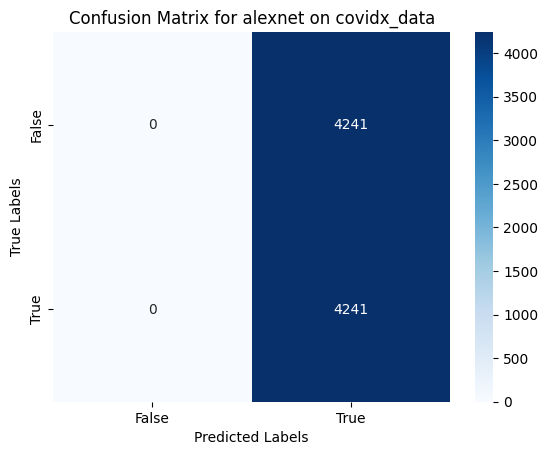

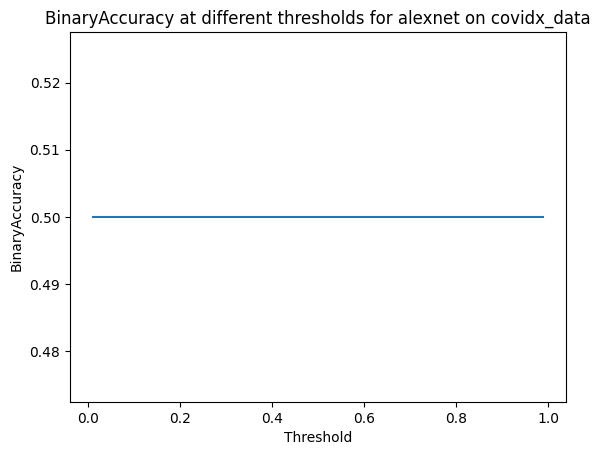

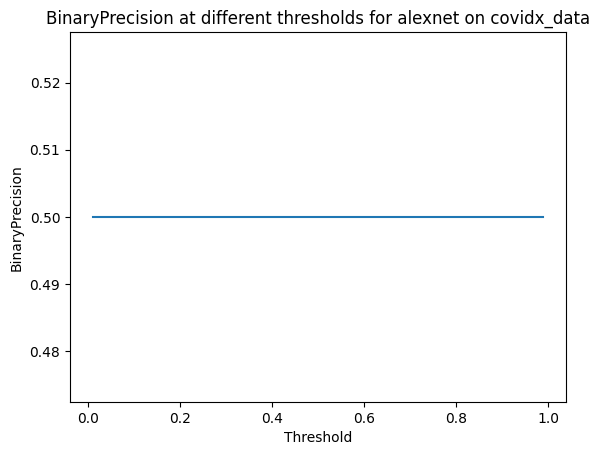

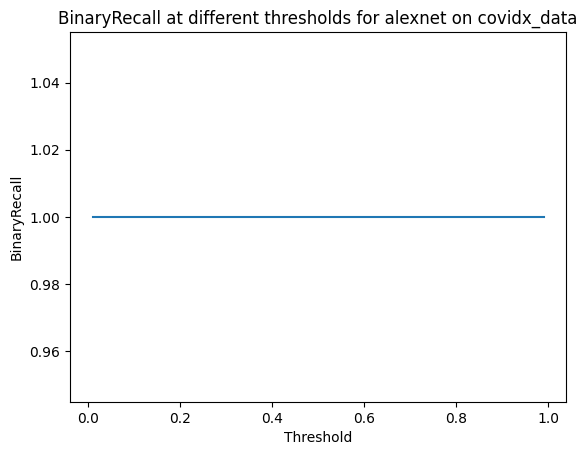

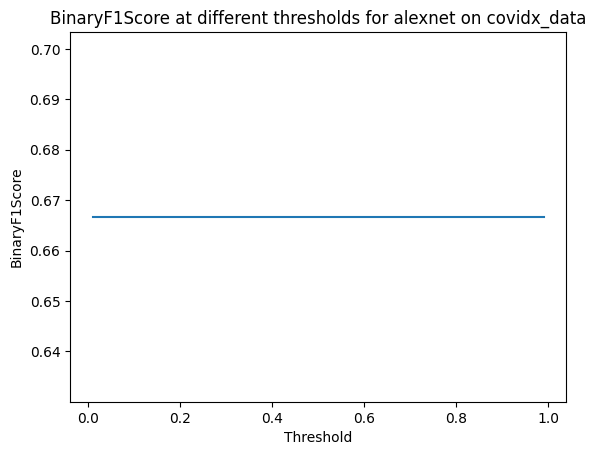

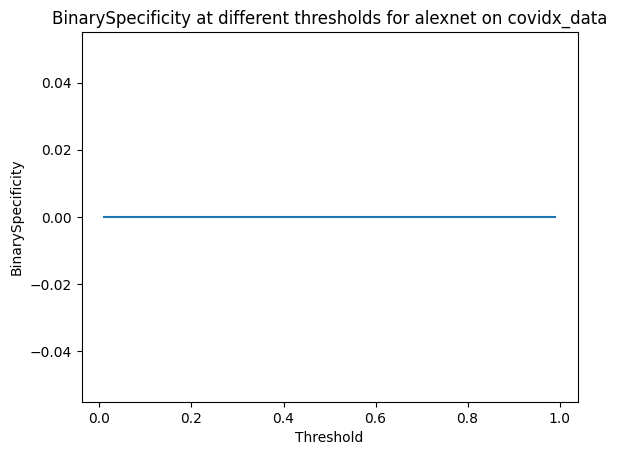


Model: densenet121 - Dataset: covidx_data


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth

100%|██████████| 30.8M/30.8M [00:00<00:00, 369MB/s]


Batch:   0%|          | 0/266 [00:00<?, ?it/s]

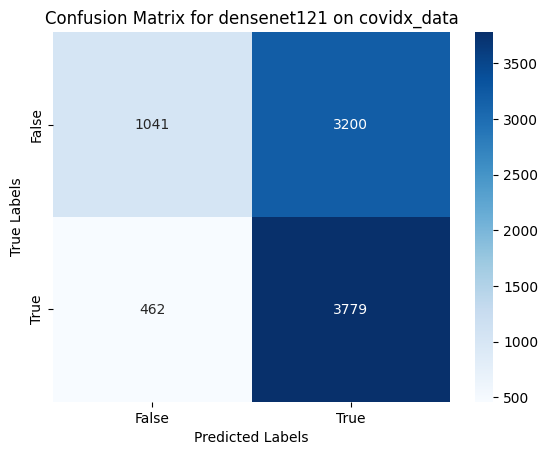

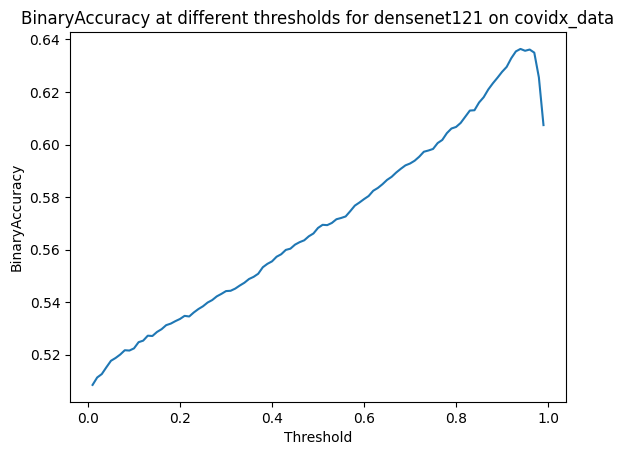

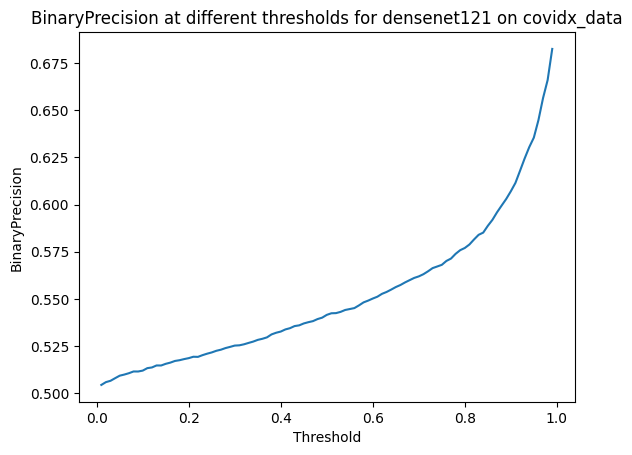

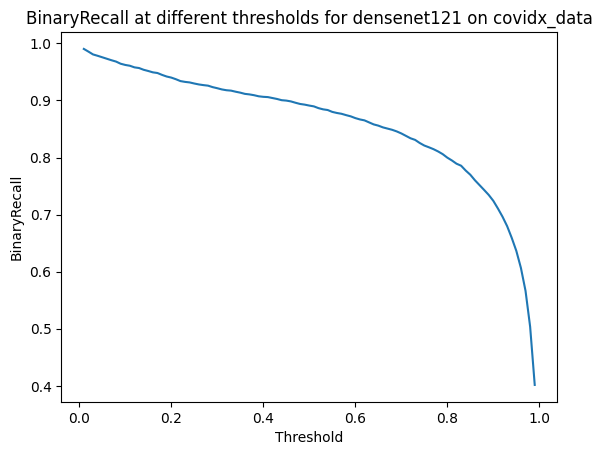

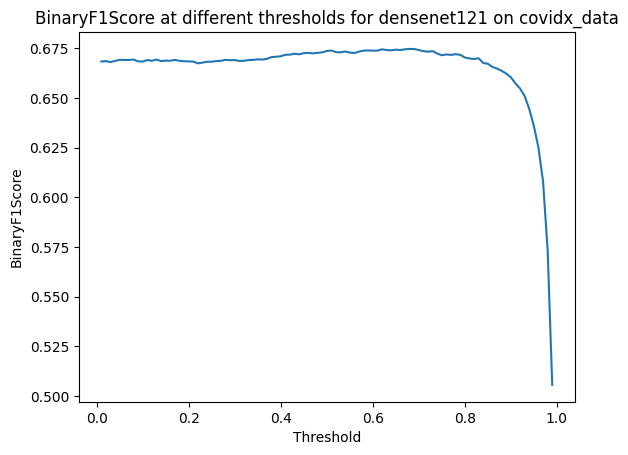

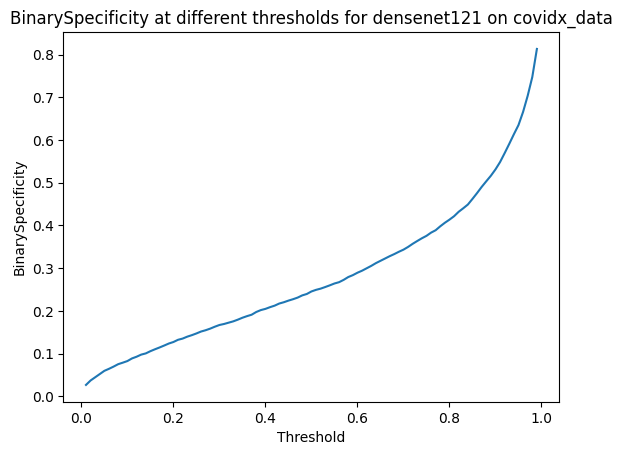


Model: densenet169 - Dataset: covidx_data


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth

  0%|          | 0.00/54.7M [00:00<?, ?B/s]
100%|██████████| 54.7M/54.7M [00:00<00:00, 365MB/s]


Batch:   0%|          | 0/266 [00:00<?, ?it/s]

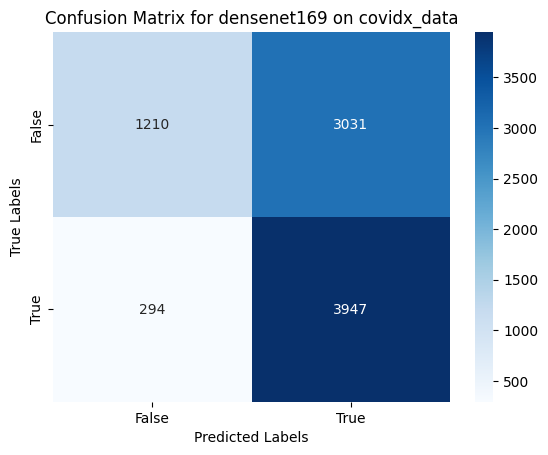

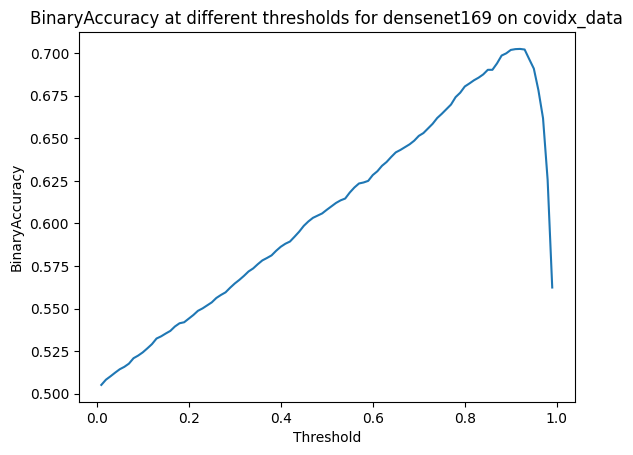

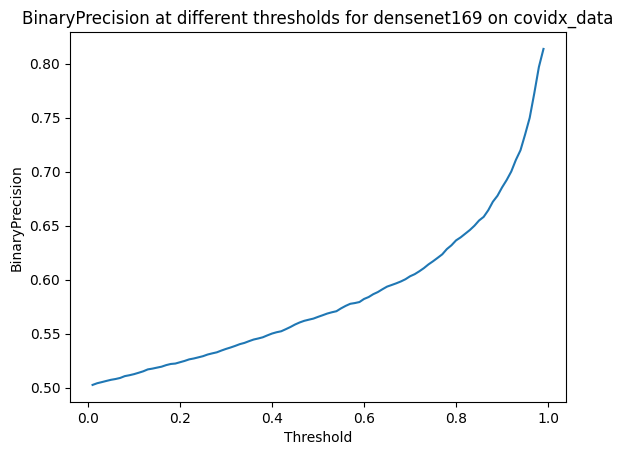

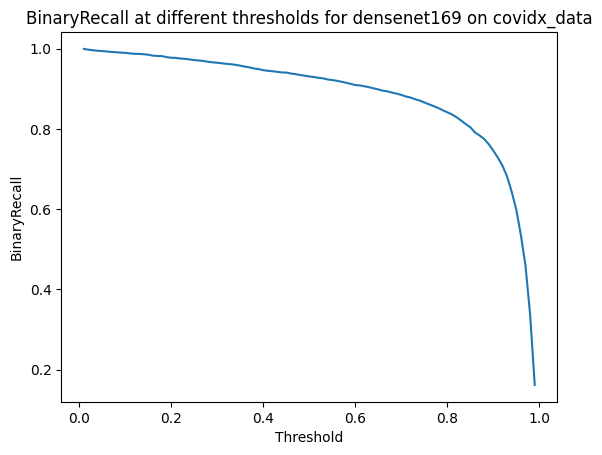

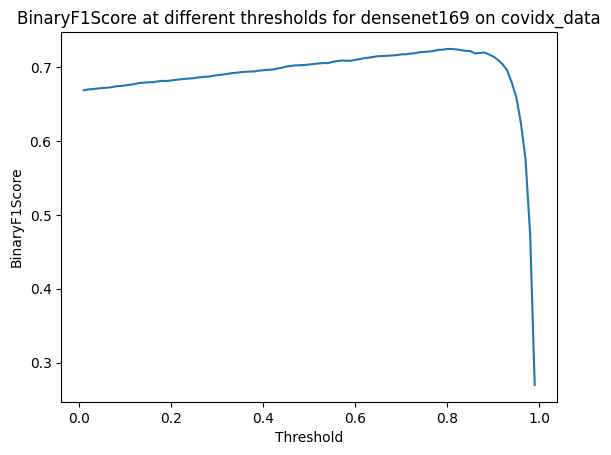

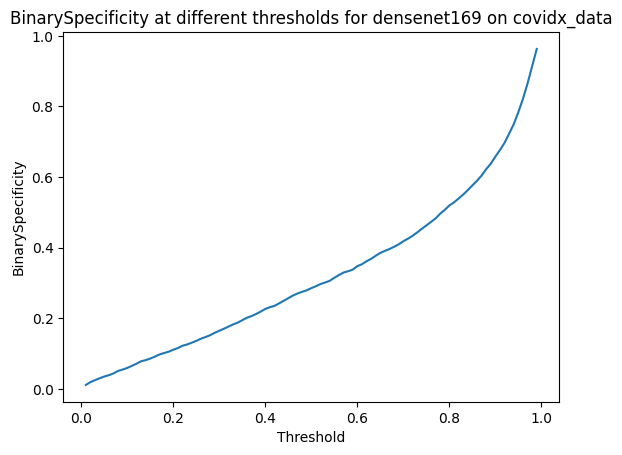


Model: densenet201 - Dataset: covidx_data


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/densenet201-c1103571.pth

  0%|          | 0.00/77.4M [00:00<?, ?B/s]
 45%|████▍     | 34.8M/77.4M [00:00<00:00, 364MB/s]
100%|██████████| 77.4M/77.4M [00:00<00:00, 367MB/s]


Batch:   0%|          | 0/266 [00:00<?, ?it/s]

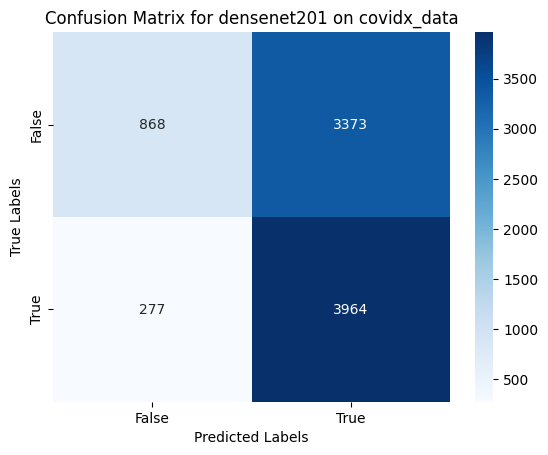

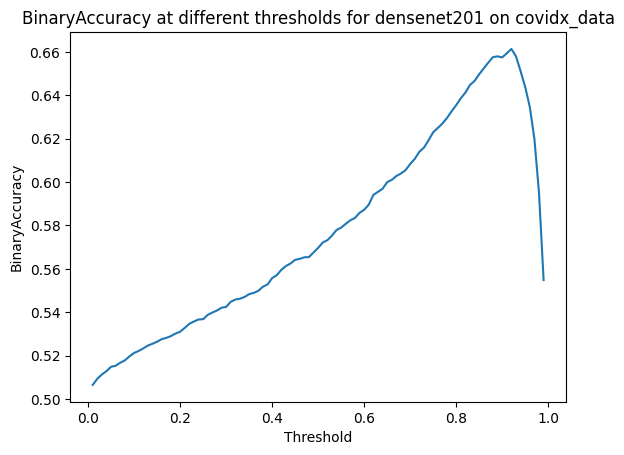

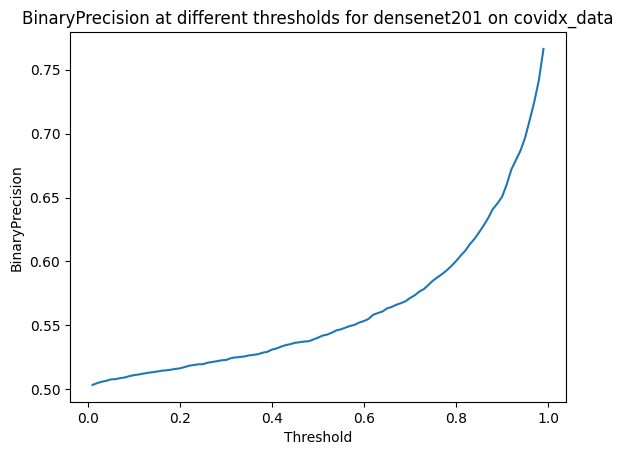

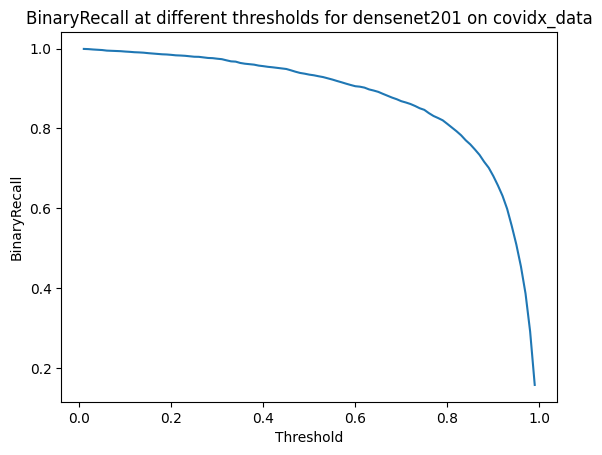

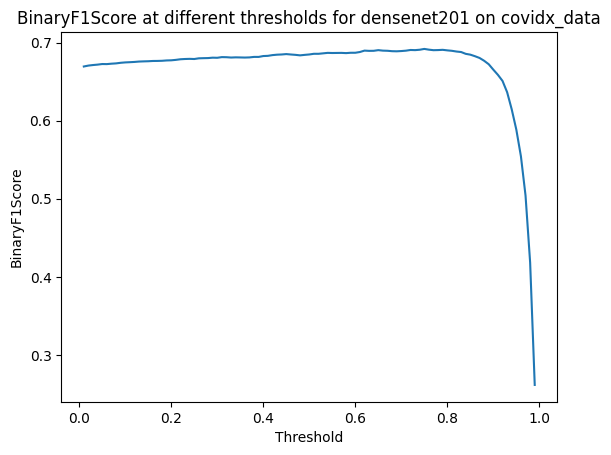

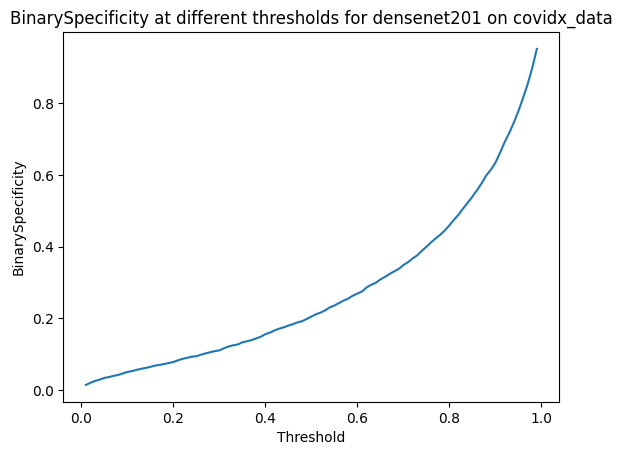


Model: efficientnet_v2_l - Dataset: covidx_data


Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth

  0%|          | 0.00/455M [00:00<?, ?B/s]
  8%|▊         | 34.5M/455M [00:00<00:01, 361MB/s]
 15%|█▌        | 69.1M/455M [00:00<00:01, 362MB/s]
 23%|██▎       | 104M/455M [00:00<00:01, 363MB/s] 
 30%|███       | 138M/455M [00:00<00:00, 363MB/s]
 38%|███▊      | 173M/455M [00:00<00:00, 364MB/s]
 46%|████▌     | 208M/455M [00:00<00:00, 364MB/s]
 53%|█████▎    | 243M/455M [00:00<00:00, 364MB/s]
 61%|██████    | 277M/455M [00:00<00:00, 364MB/s]
 69%|██████▊   | 312M/455M [00:00<00:00, 364MB/s]
 76%|███████▋  | 347M/455M [00:01<00:00, 364MB/s]
 84%|████████▍ | 382M/455M [00:01<00:00, 364MB/s]
 92%|█████████▏| 416M/455M [00:01<00:00, 363MB/s]
100%|██████████| 455M/455M [00:01<00:00, 363MB/s]


Batch:   0%|          | 0/266 [00:00<?, ?it/s]

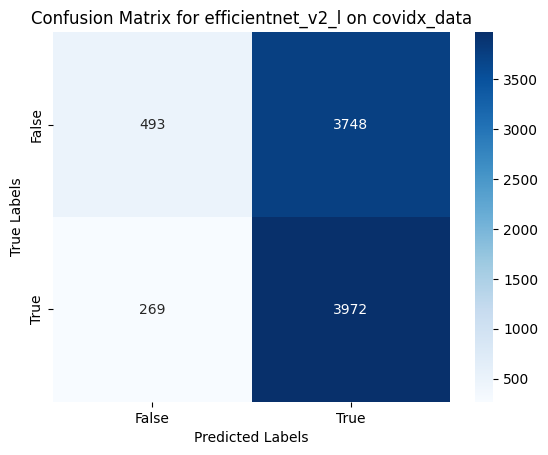

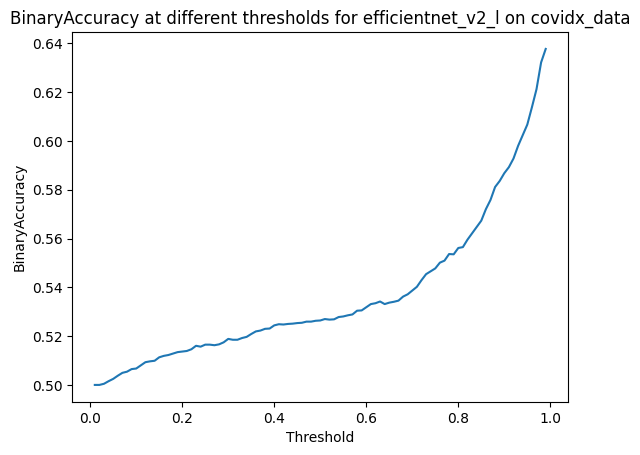

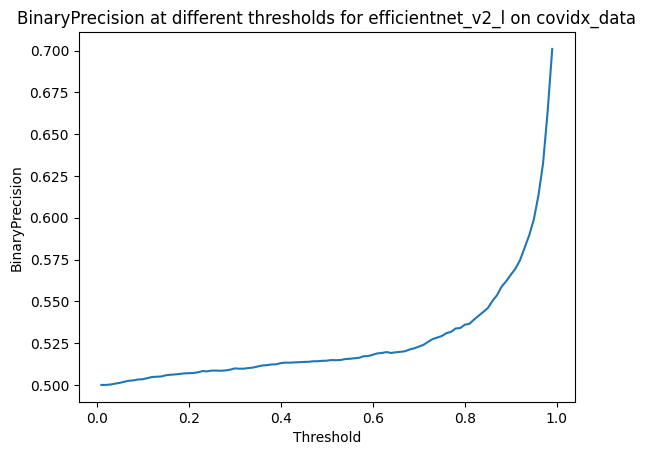

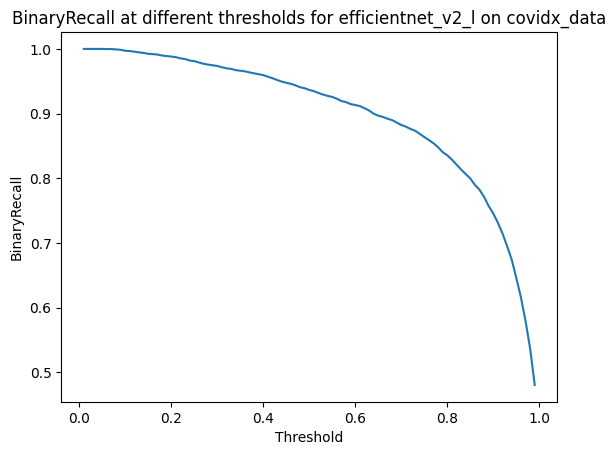

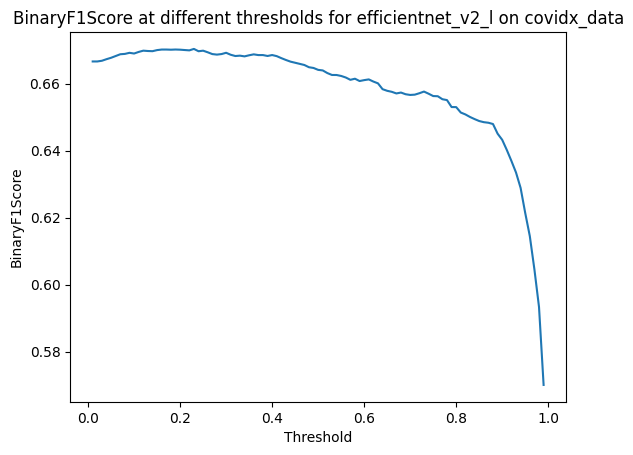

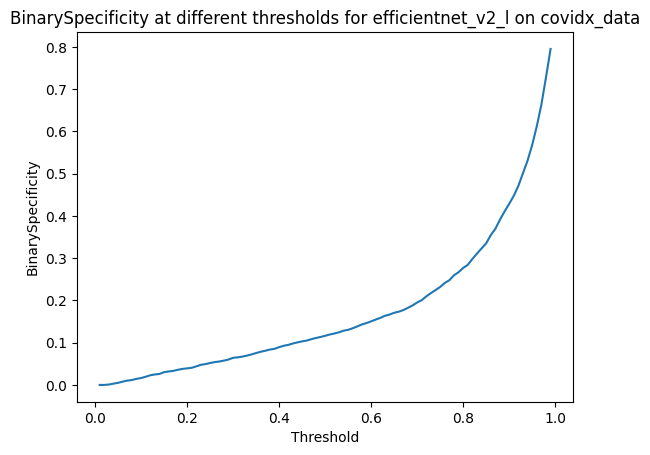


Model: efficientnet_v2_m - Dataset: covidx_data


Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth

  0%|          | 0.00/208M [00:00<?, ?B/s]
 17%|█▋        | 35.1M/208M [00:00<00:00, 368MB/s]
 34%|███▍      | 70.5M/208M [00:00<00:00, 370MB/s]
 51%|█████     | 106M/208M [00:00<00:00, 371MB/s] 
 68%|██████▊   | 141M/208M [00:00<00:00, 370MB/s]
100%|██████████| 208M/208M [00:00<00:00, 371MB/s]


Batch:   0%|          | 0/266 [00:00<?, ?it/s]

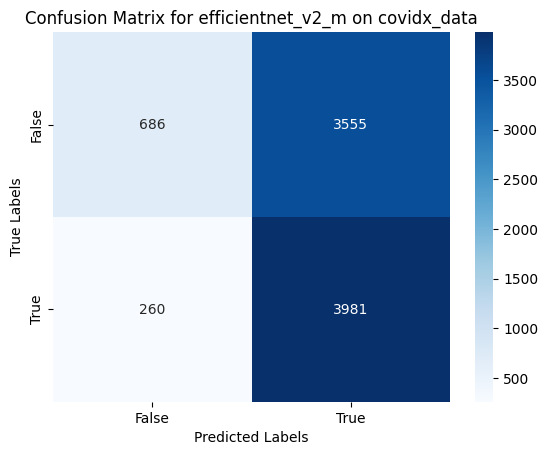

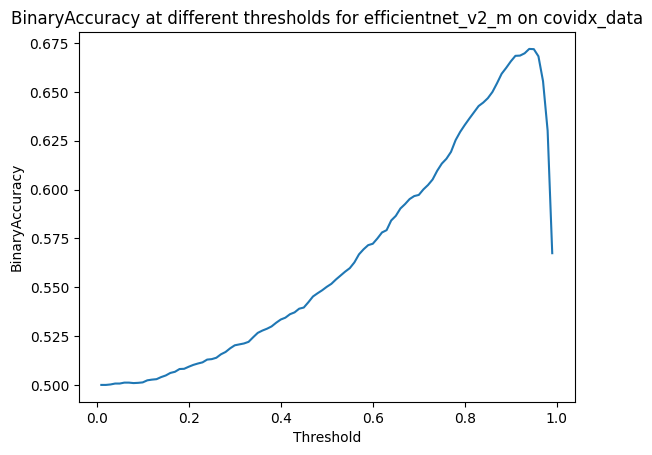

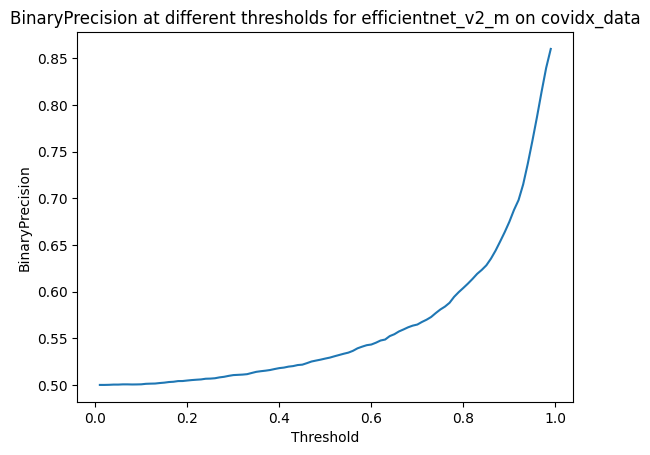

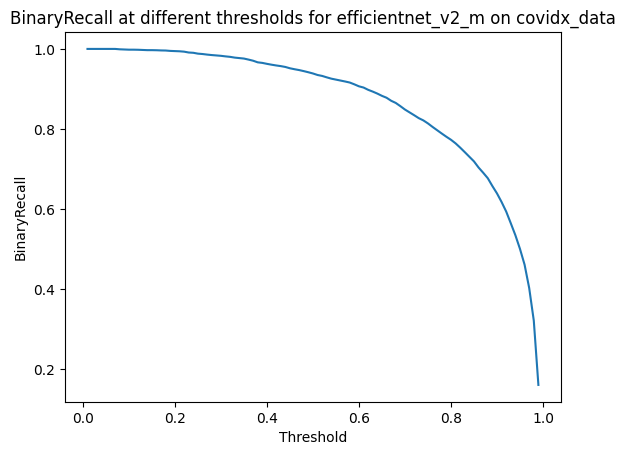

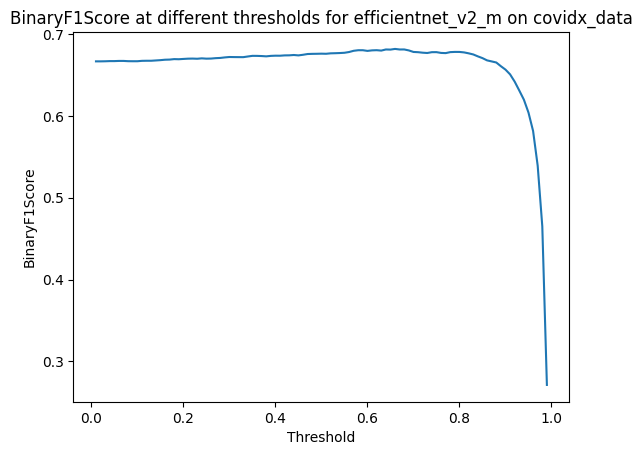

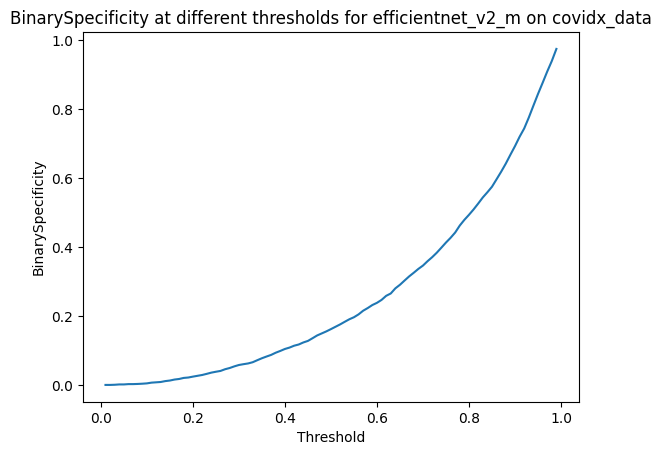


Model: efficientnet_v2_s - Dataset: covidx_data


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth

  0%|          | 0.00/82.7M [00:00<?, ?B/s]
 41%|████      | 34.0M/82.7M [00:00<00:00, 357MB/s]
100%|██████████| 82.7M/82.7M [00:00<00:00, 365MB/s]


Batch:   0%|          | 0/266 [00:00<?, ?it/s]

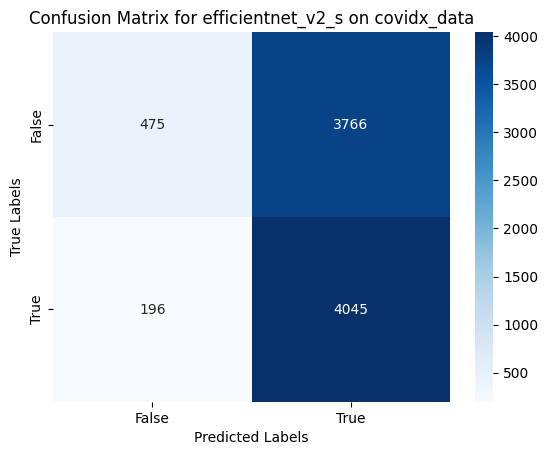

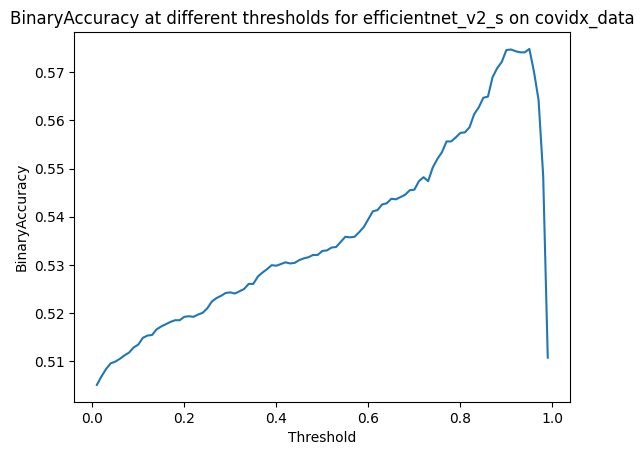

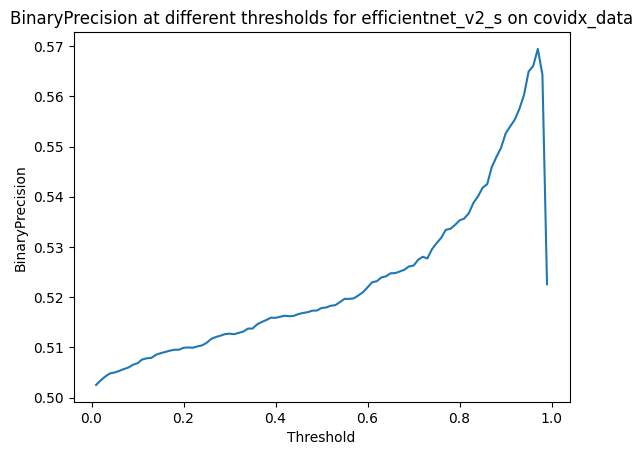

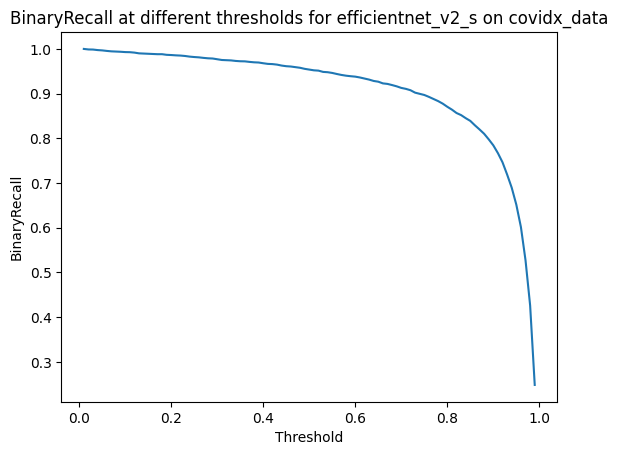

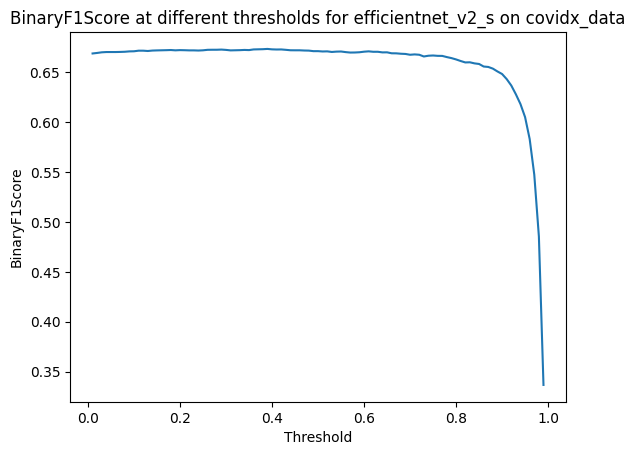

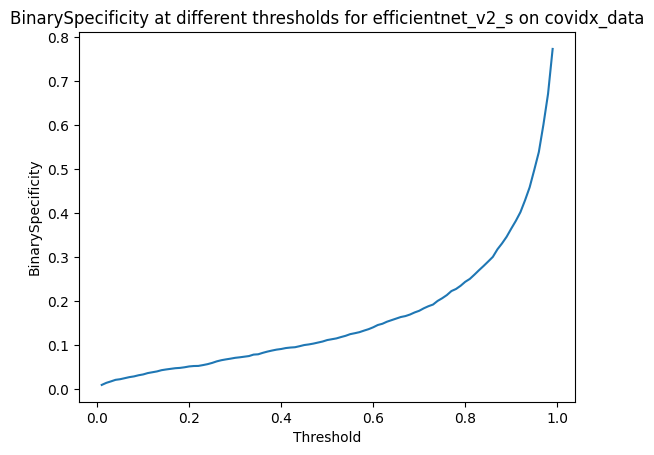


Model: resnet152 - Dataset: covidx_data


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth

  0%|          | 0.00/230M [00:00<?, ?B/s]
 15%|█▍        | 34.4M/230M [00:00<00:00, 361MB/s]
 30%|███       | 69.7M/230M [00:00<00:00, 366MB/s]
 46%|████▌     | 106M/230M [00:00<00:00, 371MB/s] 
 61%|██████    | 141M/230M [00:00<00:00, 368MB/s]
 77%|███████▋  | 177M/230M [00:00<00:00, 370MB/s]
100%|██████████| 230M/230M [00:00<00:00, 368MB/s]


Batch:   0%|          | 0/266 [00:00<?, ?it/s]

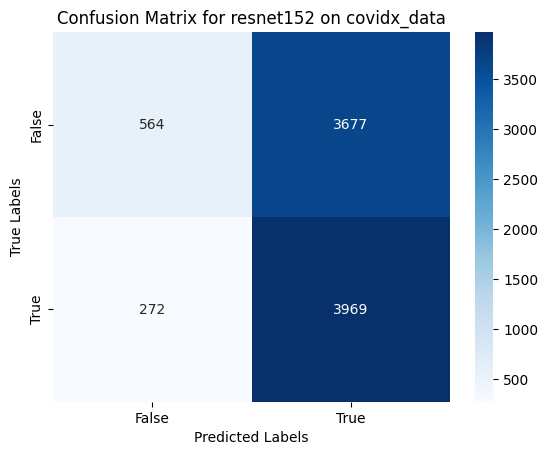

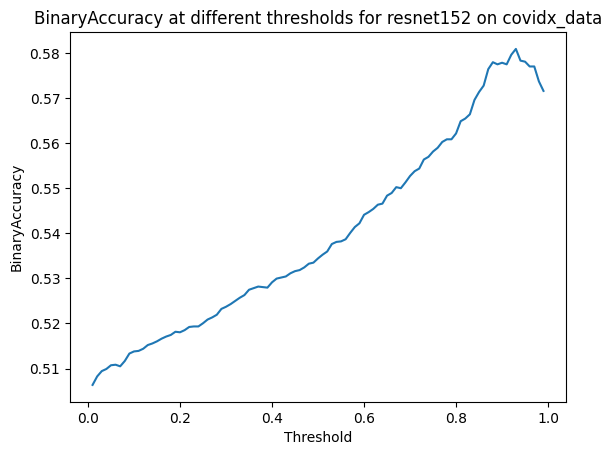

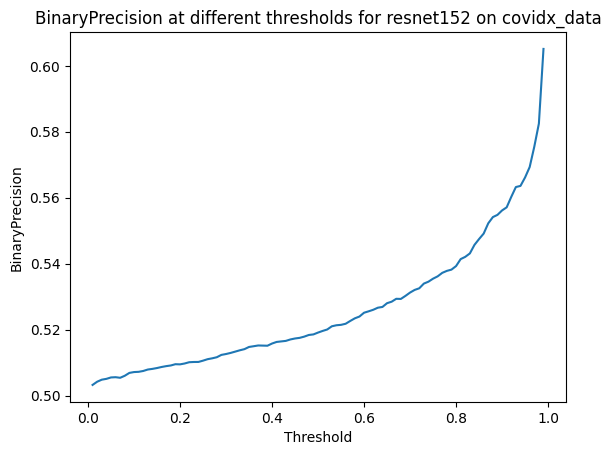

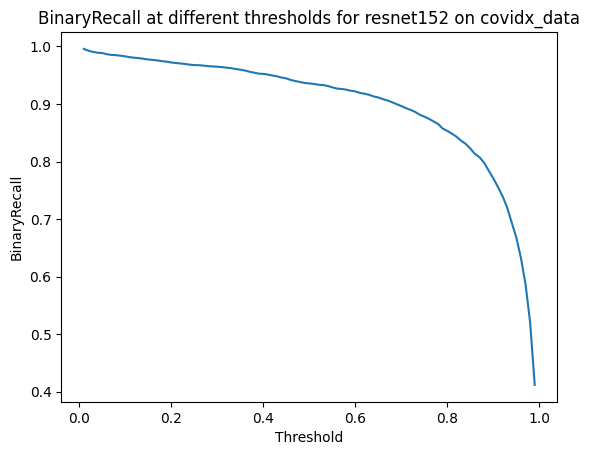

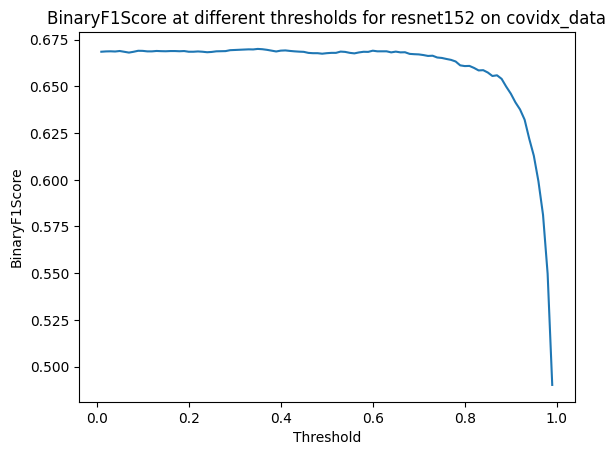

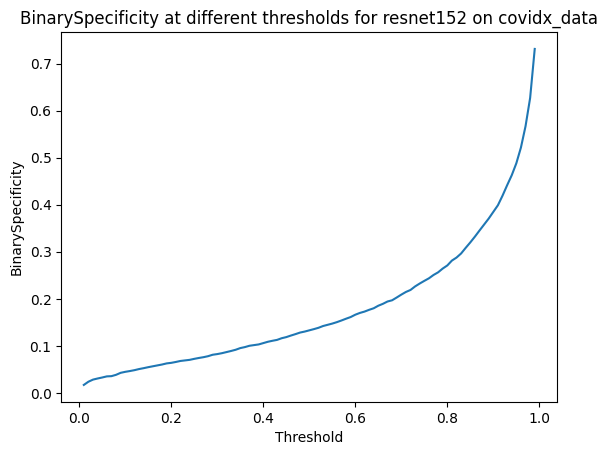


Model: resnet18 - Dataset: covidx_data


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

  0%|          | 0.00/44.7M [00:00<?, ?B/s]
100%|██████████| 44.7M/44.7M [00:00<00:00, 363MB/s]


Batch:   0%|          | 0/266 [00:00<?, ?it/s]

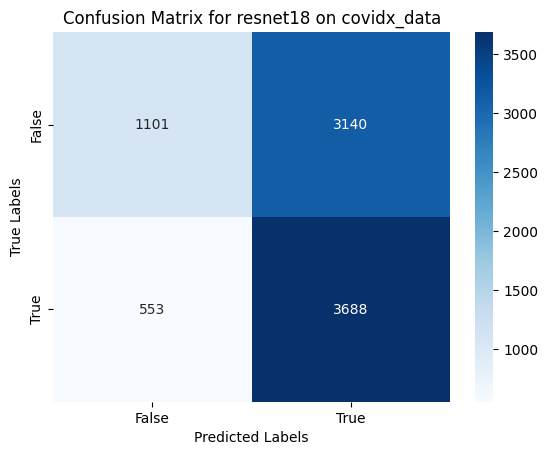

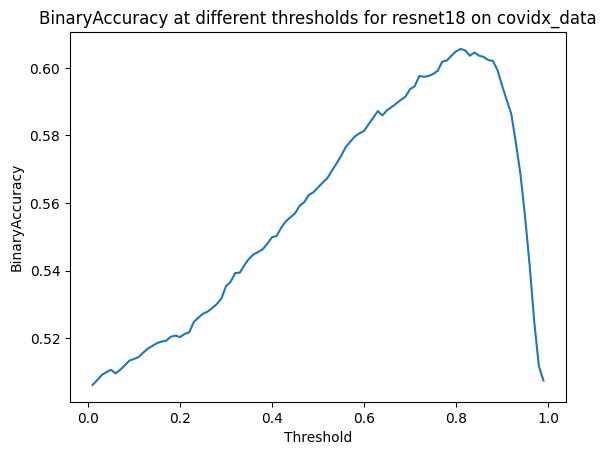

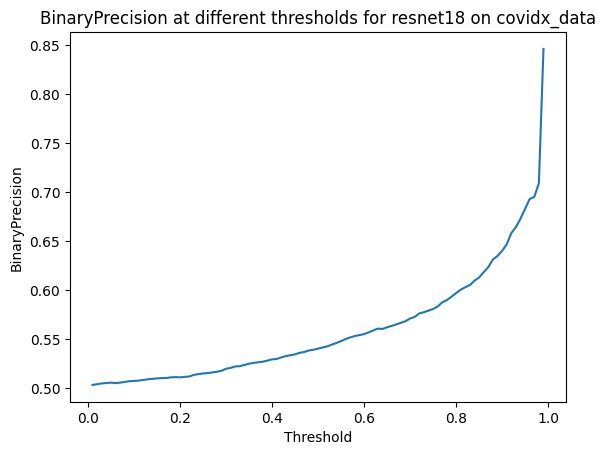

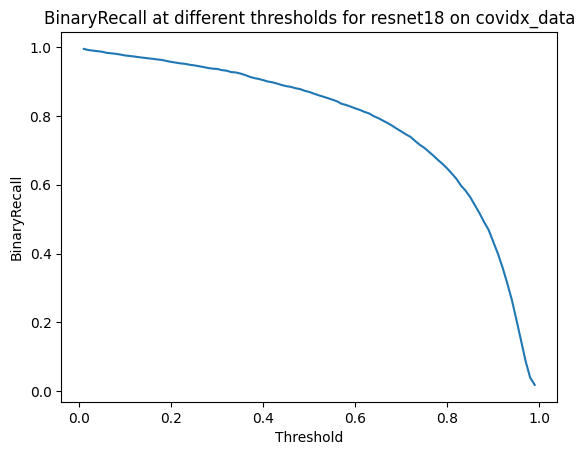

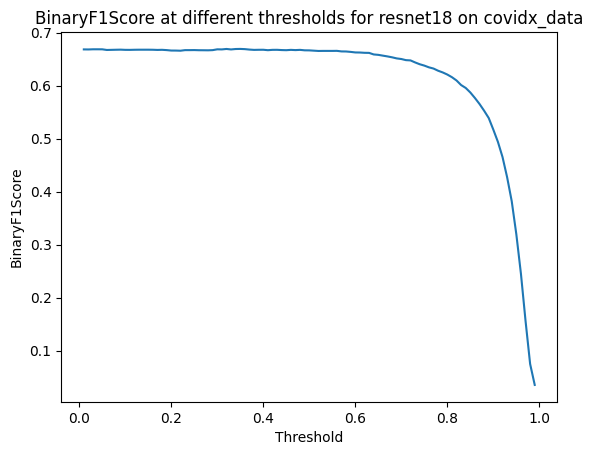

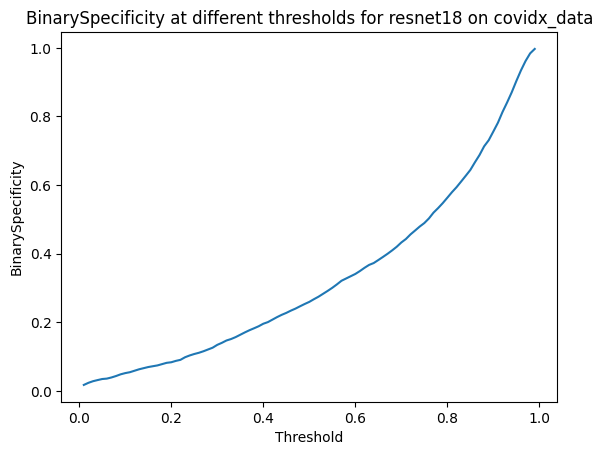


Model: resnet50 - Dataset: covidx_data


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth

  0%|          | 0.00/97.8M [00:00<?, ?B/s]
 35%|███▌      | 34.5M/97.8M [00:00<00:00, 362MB/s]
100%|██████████| 97.8M/97.8M [00:00<00:00, 369MB/s]


Batch:   0%|          | 0/266 [00:00<?, ?it/s]

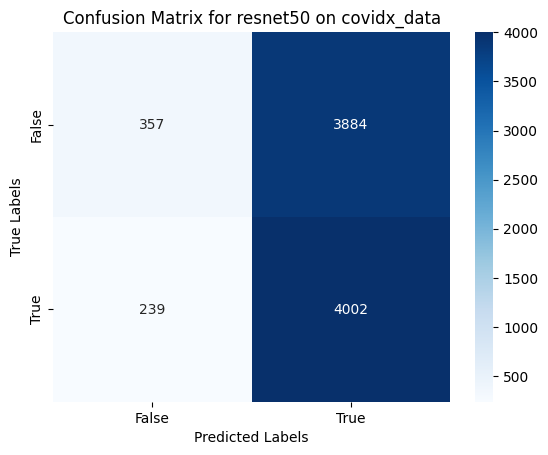

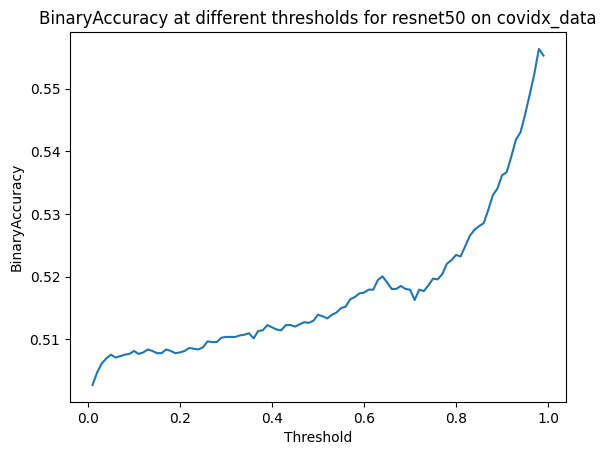

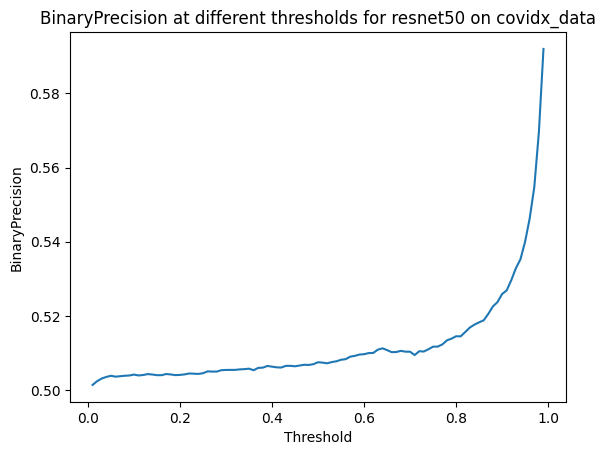

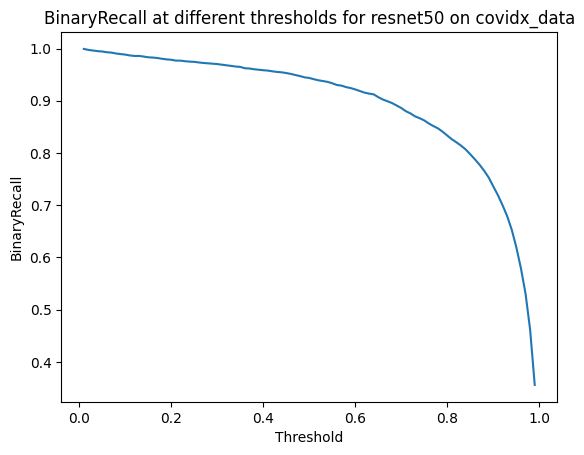

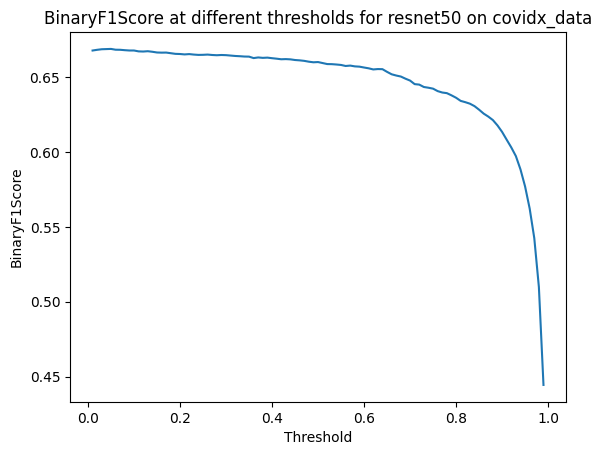

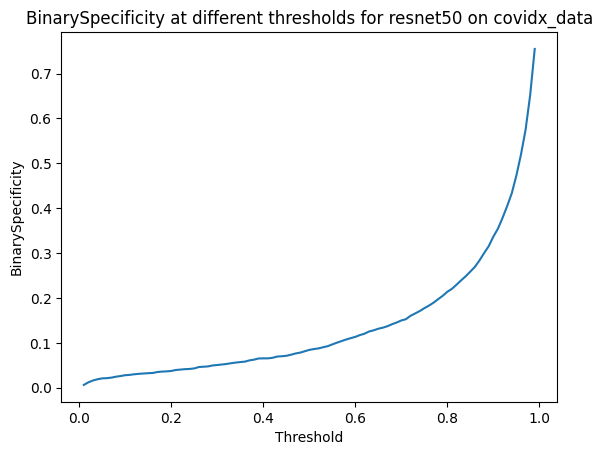


Model: vgg11 - Dataset: covidx_data


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/vgg11-8a719046.pth

  0%|          | 0.00/507M [00:00<?, ?B/s]
  7%|▋         | 34.5M/507M [00:00<00:01, 362MB/s]
 14%|█▍        | 69.8M/507M [00:00<00:01, 367MB/s]
 21%|██        | 105M/507M [00:00<00:01, 368MB/s] 
 28%|██▊       | 141M/507M [00:00<00:01, 370MB/s]
 35%|███▍      | 176M/507M [00:00<00:00, 369MB/s]
 42%|████▏     | 212M/507M [00:00<00:00, 371MB/s]
 49%|████▉     | 247M/507M [00:00<00:00, 371MB/s]
 56%|█████▌    | 283M/507M [00:00<00:00, 371MB/s]
 63%|██████▎   | 318M/507M [00:00<00:00, 371MB/s]
 70%|██████▉   | 354M/507M [00:01<00:00, 372MB/s]
 77%|███████▋  | 389M/507M [00:01<00:00, 370MB/s]
 84%|████████▍ | 425M/507M [00:01<00:00, 372MB/s]
 91%|█████████ | 460M/507M [00:01<00:00, 371MB/s]
100%|██████████| 507M/507M [00:01<00:00, 370MB/s]


Batch:   0%|          | 0/266 [00:00<?, ?it/s]

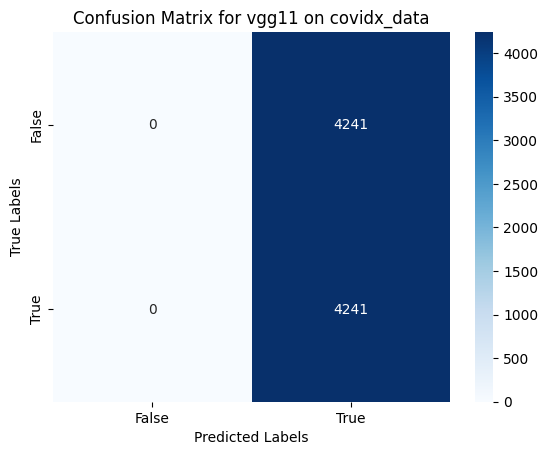

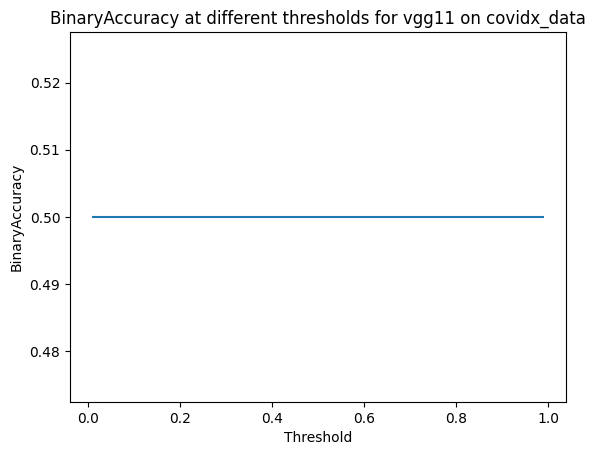

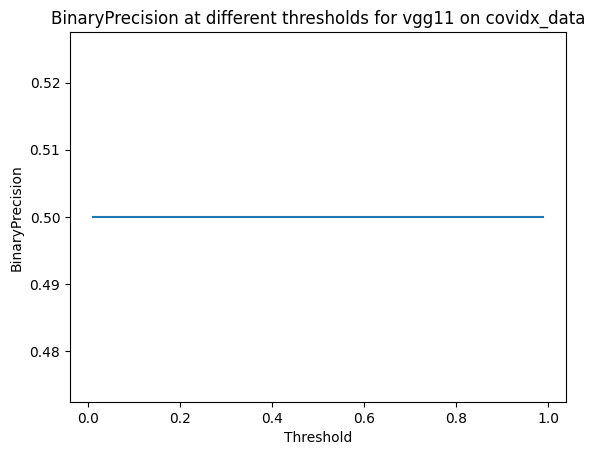

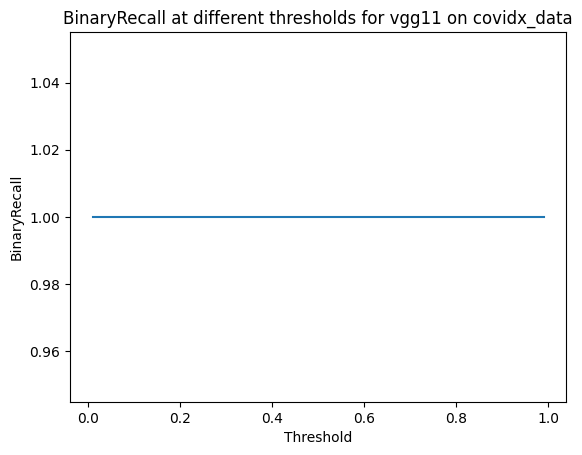

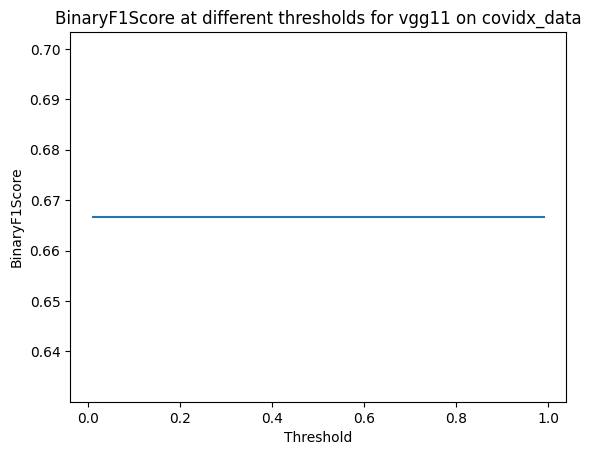

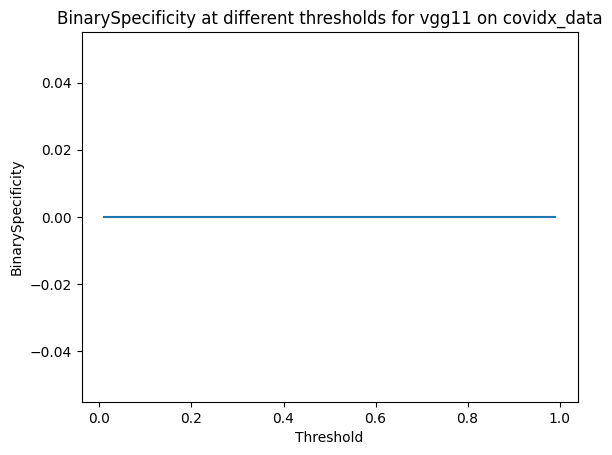


Model: vit_b_16 - Dataset: covidx_data


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth

  0%|          | 0.00/330M [00:00<?, ?B/s]
 10%|█         | 34.6M/330M [00:00<00:00, 363MB/s]
 21%|██        | 69.6M/330M [00:00<00:00, 365MB/s]
 32%|███▏      | 104M/330M [00:00<00:00, 365MB/s] 
 42%|████▏     | 140M/330M [00:00<00:00, 368MB/s]
 53%|█████▎    | 175M/330M [00:00<00:00, 366MB/s]
 64%|██████▎   | 210M/330M [00:00<00:00, 368MB/s]
 74%|███████▍  | 245M/330M [00:00<00:00, 367MB/s]
 85%|████████▍ | 281M/330M [00:00<00:00, 367MB/s]
100%|██████████| 330M/330M [00:00<00:00, 367MB/s]


Batch:   0%|          | 0/266 [00:00<?, ?it/s]

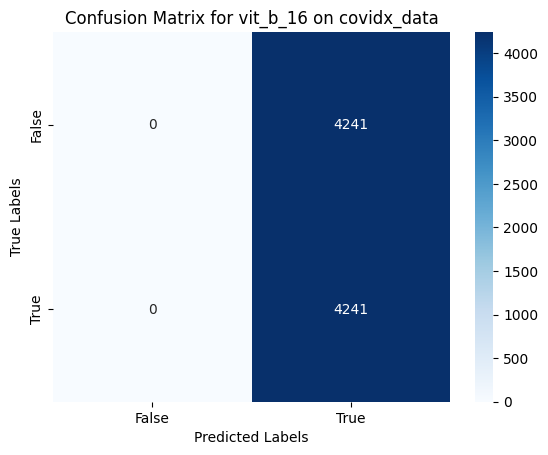

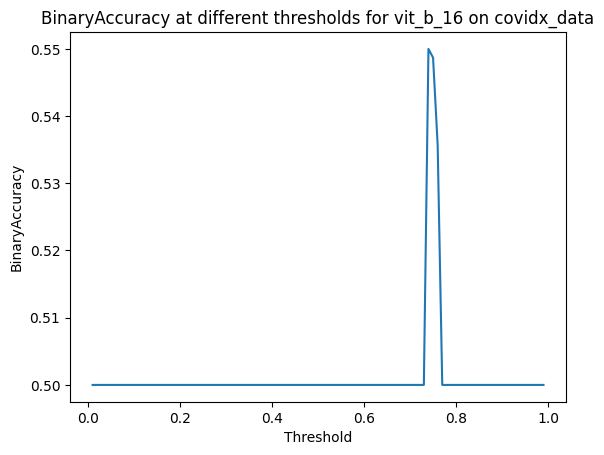

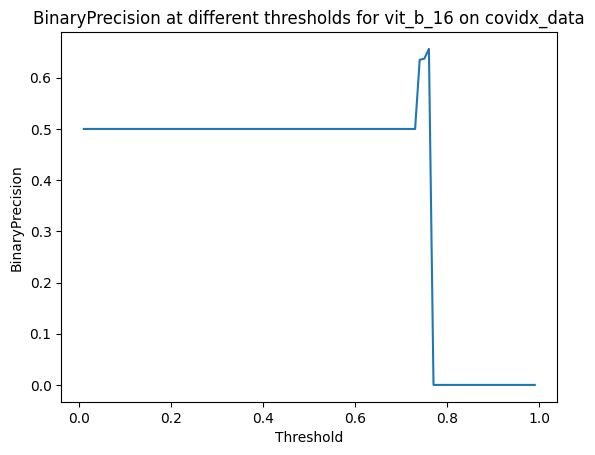

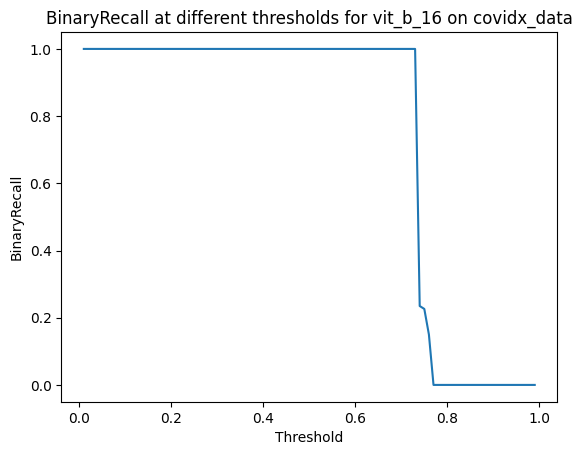

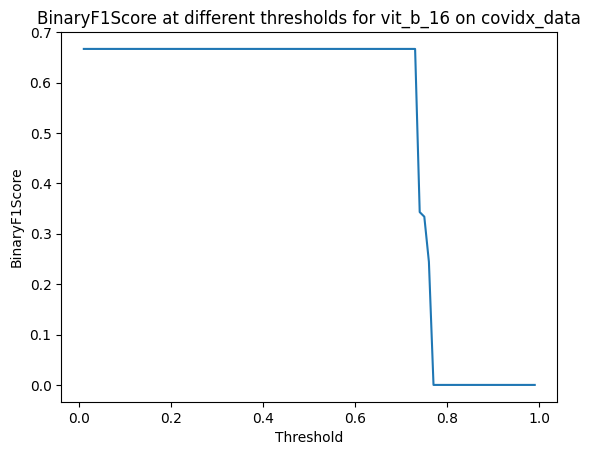

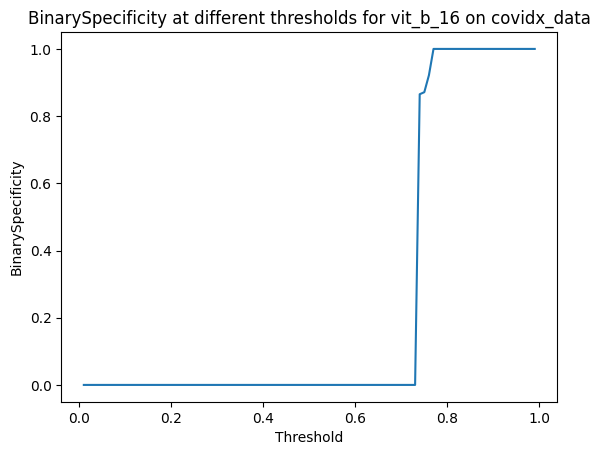


Model: alexnet - Dataset: mri_data
Processing data...


Batch:   0%|          | 0/13 [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
Exception ignored in: <function _ConnectionBase.__del__ at 0x7f80209e1f30>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
    self.run()
  File "/home/ubuntu/.local/lib/python3.10/s

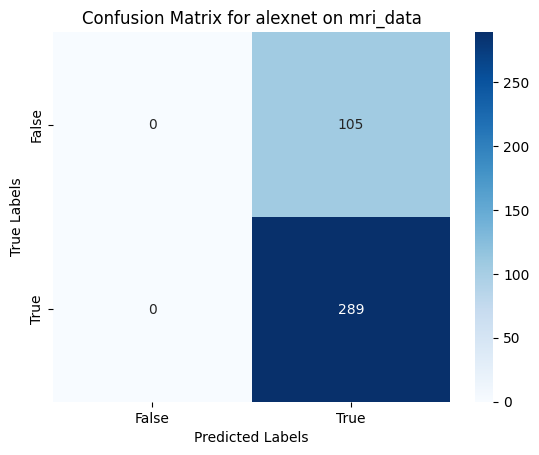

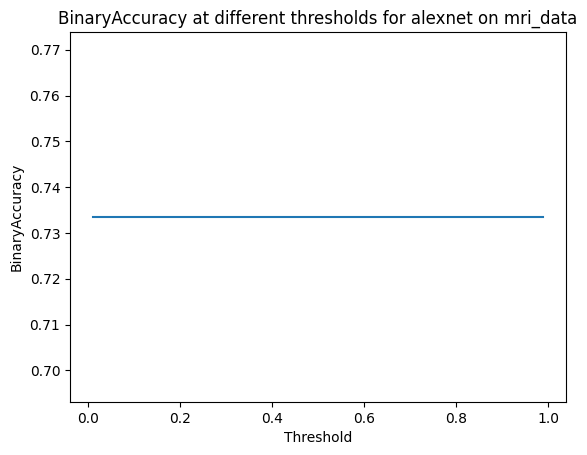

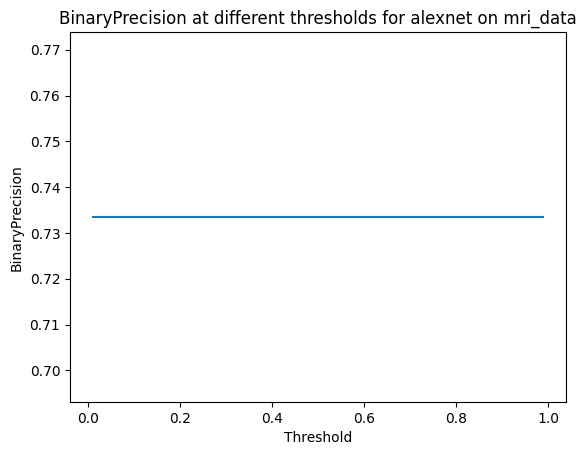

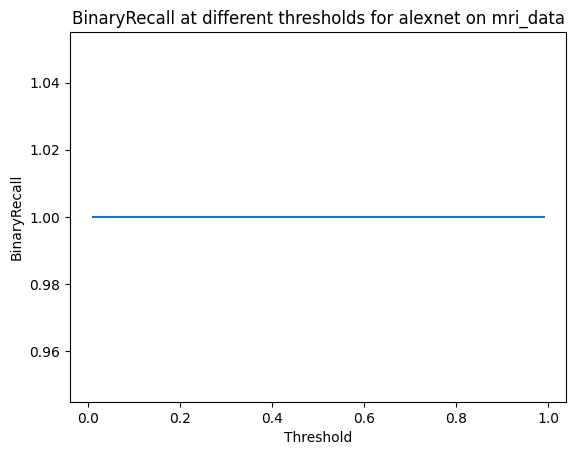

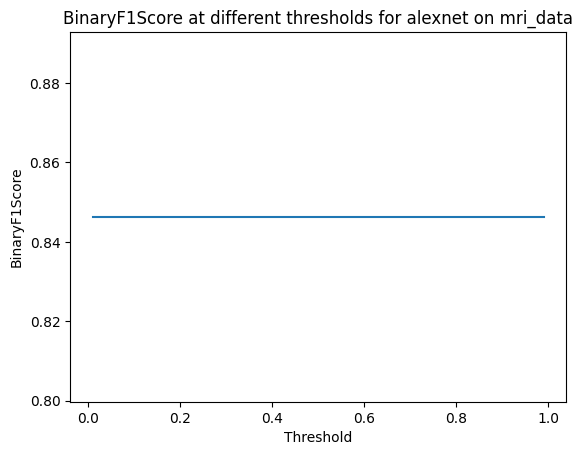

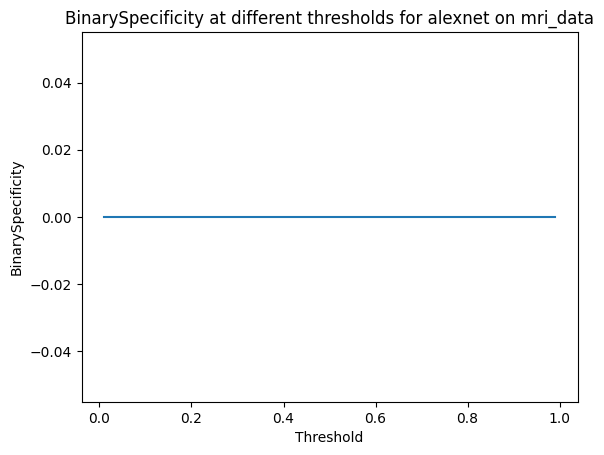


Model: densenet121 - Dataset: mri_data


Batch:   0%|          | 0/13 [00:00<?, ?it/s]

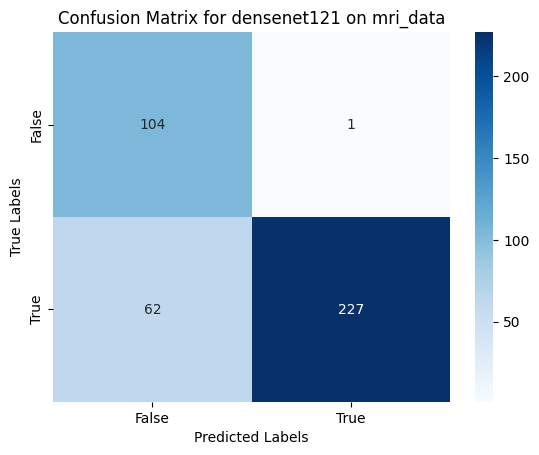

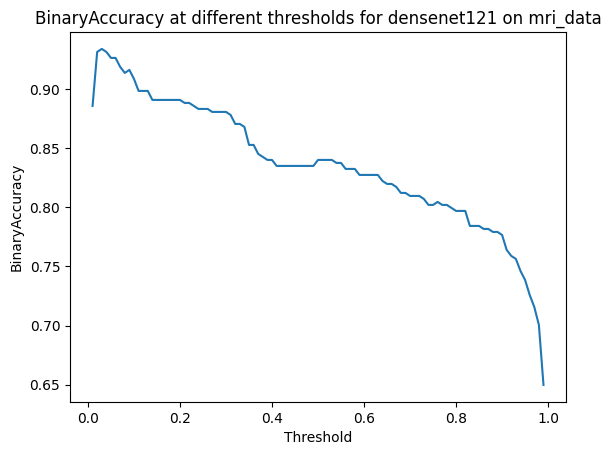

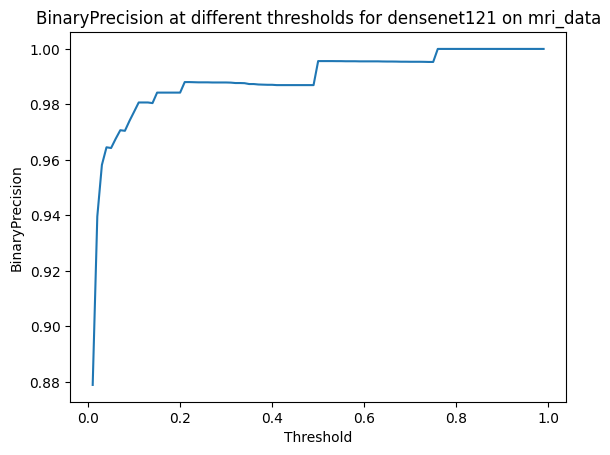

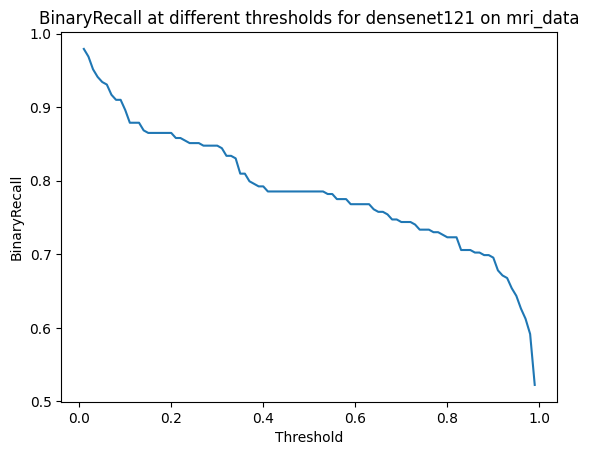

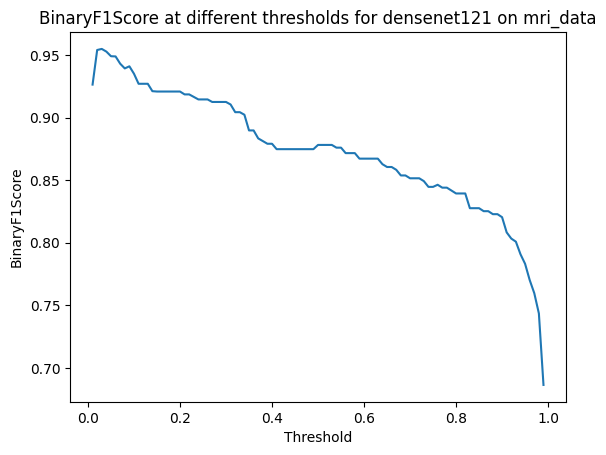

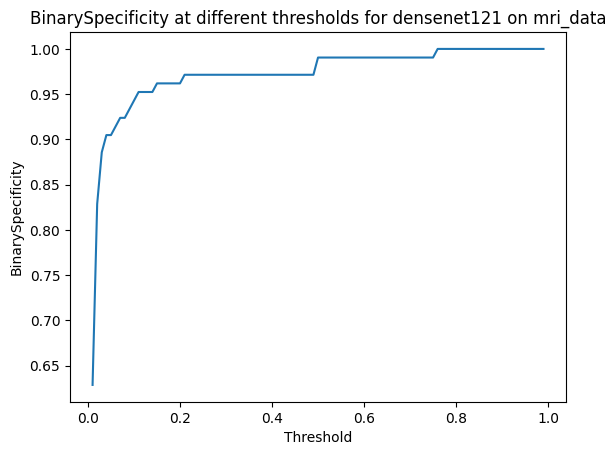


Model: densenet169 - Dataset: mri_data


Batch:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _ConnectionBase.__del__ at 0x7f80209e1f30>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [ ]:
NUM_WORKERS = 24 

for idx, metadata in tqdm(best_models.iterrows(), desc="Model - Dataset Pair", position=0, total=len(best_models)):
    print(f"\nModel: {metadata.model} - Dataset: {metadata.dataset}")
    
    model_artifact = wandb.Api().artifact(f"{ENTITY}/{PROJECT}/model-{metadata.id}:best", type="model")
    model_folder_path = f"models/{metadata.model}-{metadata.dataset}/"
    model_path = model_artifact.file(root=model_folder_path)

    if metadata.dataset == "covidx_data":
        datamodule = COVIDXDataModule(
            path="data/raw/COVIDX-CXR4",
            transform=transform,
            num_workers=NUM_WORKERS,
            batch_size=metadata.batch_size,
            train_sample_size=0.05,
            train_shuffle=True,
        ).setup()
    elif metadata.dataset == "mri_data":
        datamodule = MRIDataModule(
            path="data/raw/Brain-Tumor-MRI",
            path_processed="data/processed/Brain-Tumor-MRI",
            transform=transform,
            num_workers=NUM_WORKERS,
            batch_size=metadata.batch_size,
            train_shuffle=True,
        ).setup()

    model = ImageClassifier.load_from_checkpoint(
        checkpoint_path=model_path,
        modelname=metadata.model,
        output_size=1,
        p_dropout_classifier=metadata.p_dropout_classifier,
        lr=metadata.lr,
        weight_decay=metadata.weight_decay,
    )

    model.freeze()
    model.eval()
    model.to(device)

    y_trues = []
    y_preds = []

    for batch in tqdm(datamodule.test_dataloader(), leave=False, desc="Batch", position=1):
        x, y = batch
        y_hat = model.predict(x.to(device))
        y_trues.append(y.to(device))
        y_preds.append(y_hat)

    y_trues = torch.cat(y_trues)
    y_preds = torch.cat(y_preds).squeeze(1)

    metrics_dict = metrics(y_preds.cpu(), y_trues.cpu())
    metrics_dict = {k: v.item() for k, v in metrics_dict.items()}

    with open(f"{model_folder_path}/test_metrics.json", "w") as f:
        json.dump(metrics_dict, f)
    
    metrics_vis = Metrics(y_preds = y_preds.cpu(), y_trues = y_trues.cpu())

    metrics_vis.visualize_confusion_matrix(model=metadata.model, dataset=metadata.dataset)
    metrics_vis.visualize_threshold_metric_plot("BinaryAccuracy", model=metadata.model, dataset=metadata.dataset)
    metrics_vis.visualize_threshold_metric_plot("BinaryPrecision", model=metadata.model, dataset=metadata.dataset)
    metrics_vis.visualize_threshold_metric_plot("BinaryRecall", model=metadata.model, dataset=metadata.dataset)
    metrics_vis.visualize_threshold_metric_plot("BinaryF1Score", model=metadata.model, dataset=metadata.dataset)
    metrics_vis.visualize_threshold_metric_plot("BinarySpecificity", model=metadata.model, dataset=metadata.dataset)